<a href="https://colab.research.google.com/github/kimzn4230/aideeplearning/blob/main/0513%ED%99%94_Bert_%EA%B9%80%EC%95%84%EC%97%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd  # → 데이터 로딩 및 가공을 위한 판다스(Pandas) 사용

from sklearn.model_selection import train_test_split # → 데이터를 학습용/검증용으로 나누기 위한 scikit-learn의 함수.

#from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments  # → 아래 참고

from datasets import Dataset # → 모델 입력에 맞는 Dataset 객체로 변환

import torch # → GPU/CPU 장치 제어 및 텐서 연산을 위한 PyTorch

from tqdm import tqdm # for 루프 진행 상황을 실시간으로 보여주는 진행 바 라이브러리

In [ ]:
import pandas as pd

In [ ]:
train = pd.read_csv('/content/train.csv') # train.csv 파일을 불러와서 train이라는 DataFrame으로 저장 (4개의 문장 + 해당 정답 순서가 담긴 학습 데이터)

###1차 시도

In [ ]:
from transformers import BertTokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained("monologg/kobert")
# BERT 아키텍처 토크나이저 클래스지만
# 실제로는 KoBERT 모델에 맞게 학습된 토크나이저를 사용하는 것

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/263 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [ ]:
from torch.utils.data import Dataset
from itertools import permutations

class SentenceOrderDataset(Dataset):
    def __init__(self, csv_path, tokenizer, max_len=256):
        self.data = pd.read_csv(csv_path)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.perm_map = list(permutations([0, 1, 2, 3]))  # 4! = 24가지 순서

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        sentences = [row[f"sentence_{i}"] for i in range(4)]
        answer = [row[f"answer_{i}"] for i in range(4)]

        combined = "[SEP]".join(sentences)
        encoding = self.tokenizer(
            combined,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        label = self.perm_map.index(tuple(answer))

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": label
        }

In [ ]:
train_dataset = SentenceOrderDataset('/content/train.csv', tokenizer)

In [ ]:
from transformers import BertConfig
from transformers import BertModel, BertPreTrainedModel
import torch.nn as nn

class KoBERTOrderModel(BertPreTrainedModel):
    def __init__(self, config, num_classes=24):
        super().__init__(config)
        self.bert = BertModel(config)
        self.classifier = nn.Linear(config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]
        logits = self.classifier(cls_output)

        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}


In [ ]:
config = BertConfig.from_pretrained("monologg/kobert", num_labels=24)
model = KoBERTOrderModel.from_pretrained("monologg/kobert", config=config)

config.json:   0%|          | 0.00/426 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

Some weights of KoBERTOrderModel were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import AdamW  # ✅ 최신 방식
from tqdm import tqdm

# 하이퍼파라미터 설정
batch_size = 4
num_epochs = 3
learning_rate = 2e-5

# 데이터 로더 준비
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 모델을 GPU로 이동 (가능할 경우)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=learning_rate)

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # 순전파
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs["loss"]

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_dataloader)
    print(f"✅ Epoch {epoch+1} finished. Average Loss: {avg_loss:.4f}")


Epoch 1: 100%|██████████| 1838/1838 [06:01<00:00,  5.08it/s, loss=3.05]


✅ Epoch 1 finished. Average Loss: 3.1933


Epoch 2: 100%|██████████| 1838/1838 [06:05<00:00,  5.03it/s, loss=3.26]


✅ Epoch 2 finished. Average Loss: 3.1887


Epoch 3: 100%|██████████| 1838/1838 [06:05<00:00,  5.03it/s, loss=3.21]

✅ Epoch 3 finished. Average Loss: 3.1860


In [ ]:
model.eval()  # 평가 모드로 전환
correct = 0
total = 0


with torch.no_grad():
    for batch in train_dataloader:  # 평가할 데이터셋으로 변경 가능
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs["logits"]
        preds = torch.argmax(logits, dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)
accuracy = correct / total
print(f"Final Accuracy: {accuracy:.4f}")


Final Accuracy: 0.0416


### 2차 시도


✅ 1단계: 문장 임베딩 저장하기

1-1. 사전 준비

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
from itertools import permutations

# 24가지 순열 사전
perm_map = list(permutations([0, 1, 2, 3]))
perm2idx = {p: i for i, p in enumerate(perm_map)}

# 데이터 불러오기
df = pd.read_csv("/content/train.csv")

# KoBERT 준비
tokenizer = BertTokenizer.from_pretrained("monologg/kobert")
model = BertModel.from_pretrained("monologg/kobert").eval().to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/263 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


config.json:   0%|          | 0.00/426 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

1-2. 문장을 KoBERT로 임베딩하는 함수

In [ ]:
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64).to("cuda")
    with torch.no_grad():
        outputs = model(**inputs)
        cls = outputs.last_hidden_state[:, 0, :]  # [CLS] 위치 벡터
    return cls.squeeze(0).cpu()  # (768,)

1-3. 모든 데이터셋 문장을 벡터로 변환해서 저장
python
복사
편집


In [ ]:
all_embeddings = []
all_labels = []

for i in tqdm(range(len(df))):
    row = df.iloc[i]
    sentences = [row[f"sentence_{j}"] for j in range(4)]
    emb_list = [get_cls_embedding(s) for s in sentences]  # 4개 문장 → 각 768차원
    full_embedding = torch.cat(emb_list, dim=0)  # (768*4 = 3072)

    # 정답 순서 튜플
    answer = tuple(row[f"answer_{j}"] for j in range(4))
    label = perm2idx[answer]

    all_embeddings.append(full_embedding.unsqueeze(0))  # (1, 3072)
    all_labels.append(label)

# 전체 저장
X_tensor = torch.cat(all_embeddings, dim=0)  # (N, 3072)
y_tensor = torch.tensor(all_labels)  # (N,)

torch.save(X_tensor, "train_embeddings.pt")
torch.save(y_tensor, "train_labels.pt")

100%|██████████| 7351/7351 [04:19<00:00, 28.30it/s]


✅ 2단계: 저장된 벡터로 학습

2-1. Dataset 클래스 만들기

In [ ]:
from torch.utils.data import Dataset, DataLoader

class EmbeddingDataset(Dataset):
    def __init__(self, emb_path, label_path):
        self.X = torch.load(emb_path)
        self.y = torch.load(label_path)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

2-2. 모델 정의 (간단한 MLP 분류기)

In [ ]:
import torch.nn as nn

class OrderClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.ReLU(),
            nn.Linear(512, 24)
        )

    def forward(self, x):
        return self.model(x)

2-3. 학습 코드

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = EmbeddingDataset("train_embeddings.pt", "train_labels.pt")
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = OrderClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(5):
    model.train()
    total_loss = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss/len(dataloader):.4f}")

Epoch 1: Loss = 3.1612
Epoch 2: Loss = 3.1152
Epoch 3: Loss = 3.0669
Epoch 4: Loss = 3.0169
Epoch 5: Loss = 2.9681


✅ 3단계: 정확도 평가

In [ ]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        pred_class = torch.argmax(pred, dim=1)
        correct += (pred_class == y).sum().item()
        total += y.size(0)

accuracy = correct / total
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.1592


⚡train 데이터에서 일부를 val로 추출해서 학습시켜보기

In [ ]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from tqdm import tqdm

# 1. 데이터 불러오기
X = torch.load("train_embeddings.pt")
y = torch.load("train_labels.pt")

In [ ]:
# 2. train/val 분리 (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 3. Dataset 클래스
class TensorDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [ ]:
# 4. 모델 정의
class OrderClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.ReLU(),
            nn.Linear(512, 24)
        )
    def forward(self, x):
        return self.model(x)

In [ ]:
# 5. 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OrderClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 5

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0

    train_loop = tqdm(train_loader, desc=f"[Epoch {epoch}] Train", leave=False)
    for x, y in train_loop:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            val_loss += loss.item()
            predicted = torch.argmax(pred, dim=1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    acc = correct / total
    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {acc:.4f}")

[Epoch 1] Train Loss: 582.3814 | Val Loss: 145.0206 | Val Acc: 0.0544


[Epoch 2] Train Loss: 575.7367 | Val Loss: 143.5867 | Val Acc: 0.0564


[Epoch 3] Train Loss: 568.4441 | Val Loss: 141.7065 | Val Acc: 0.1027


[Epoch 4] Train Loss: 561.1052 | Val Loss: 140.4858 | Val Acc: 0.0884


[Epoch 5] Train Loss: 553.8619 | Val Loss: 138.4074 | Val Acc: 0.1258


🧠 개선을 위한 코드 업그레이드: 구조 + 정규화 + 하이퍼파라미터

 2-1. 모델 구조 개선 (Dropout 추가, 깊게 만들기)

In [ ]:
class OrderClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 24)
        )

    def forward(self, x):
        return self.model(x)

2-2. optimizer 개선 (Adam → AdamW)

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)

 2-3. epoch 수 늘리기

In [ ]:
num_epochs = 10  # 기본 5 → 10으로

2-4. 학습률 튜닝

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=1e-2)

In [ ]:
from tqdm import tqdm

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0

    for x, y in tqdm(train_loader, desc=f"[Epoch {epoch}] Train", leave=False):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            val_loss += loss.item()
            predicted = torch.argmax(pred, dim=1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    acc = correct / total
    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {acc:.4f}")


[Epoch 1] Train Loss: 544.2140 | Val Loss: 135.3459 | Val Acc: 0.1285


[Epoch 2] Train Loss: 529.2348 | Val Loss: 132.0615 | Val Acc: 0.1387


[Epoch 3] Train Loss: 514.3100 | Val Loss: 128.9947 | Val Acc: 0.1523


[Epoch 4] Train Loss: 501.0118 | Val Loss: 126.8449 | Val Acc: 0.1591


[Epoch 5] Train Loss: 489.3598 | Val Loss: 124.2286 | Val Acc: 0.1604


[Epoch 6] Train Loss: 478.1274 | Val Loss: 122.1144 | Val Acc: 0.1951


[Epoch 7] Train Loss: 468.6741 | Val Loss: 120.4626 | Val Acc: 0.2019


[Epoch 8] Train Loss: 460.3500 | Val Loss: 118.9493 | Val Acc: 0.1801


[Epoch 9] Train Loss: 453.0594 | Val Loss: 117.1784 | Val Acc: 0.2005


[Epoch 10] Train Loss: 445.6228 | Val Loss: 116.8124 | Val Acc: 0.2033


### 3차 시도

정확도 상승을 위한 노력..............

🔥 1단계. 데이터 전처리 고도화 — "순서 랜덤 셔플링"
지금까지 모델이 항상 sentence_0 ~ 3 순서로 들어갔다면,
모델은 “위치”에 과하게 의존할 수 있어!

해결:
학습 데이터를 만들 때 4개 문장을 순서를 섞어서 KoBERT에 넣고

정답도 그 섞인 순서에 맞게 라벨화 해야 함

📌 즉, 매 샘플마다 sentence 순서를 랜덤하게 섞어서 다양한 패턴을 학습하도록!

In [ ]:
import random

class SentenceOrderDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=64):
        self.data = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.perm_map = list(permutations([0, 1, 2, 3]))
        self.perm2idx = {p: i for i, p in enumerate(self.perm_map)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        sentences = [row[f"sentence_{i}"] for i in range(4)]
        answer = [row[f"answer_{i}"] for i in range(4)]

        # 실제 올바른 문장 순서
        gold_sentences = [sentences[i] for i in answer]

        # 이 문장들을 무작위로 섞는다
        permuted_idx = list(range(4))
        random.shuffle(permuted_idx)
        permuted_sentences = [gold_sentences[i] for i in permuted_idx]

        # 정답 순열: 섞인 문장이 원래 순서에서 어디로 갔는지
        inverse_perm = [permuted_idx.index(i) for i in range(4)]
        label = self.perm2idx[tuple(inverse_perm)]

        inputs = [get_cls_embedding(s) for s in permuted_sentences]
        concat_input = torch.cat(inputs, dim=0)  # (3072,)

        return concat_input, torch.tensor(label)

2단계: 이 데이터셋을 이용해서 임베딩 + 정답 라벨 저장

기존에는 sentence_0 ~ sentence_3 순서로만 임베딩했잖아?
👉 그런데 지금은 매 샘플마다 문장 순서가 랜덤하게 바뀌고 있어!
→ 그래서 각 문장묶음에 대해 다시 KoBERT로 임베딩을 뽑아야 해.

이제 모델이 단순한 위치 패턴이 아니라 문장 의미 흐름을 학습해야 하기 때문에, 완전 새로운 학습 목표라서 임베딩도 다시 해야함

MLP 모델

In [ ]:
import torch
from tqdm import tqdm
import pandas as pd
from transformers import BertTokenizer, BertModel
from itertools import permutations
import random

# 데이터 로드
df = pd.read_csv("/content/train.csv")

# KoBERT 모델 로딩
tokenizer = BertTokenizer.from_pretrained("monologg/kobert")
bert = BertModel.from_pretrained("monologg/kobert").eval().to("cuda")

# CLS 임베딩 추출 함수
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=64).to("cuda")
    with torch.no_grad():
        outputs = bert(**inputs)
        cls = outputs.last_hidden_state[:, 0, :]  # [CLS] 위치
    return cls.squeeze(0).cpu()  # (768,)

# 순열 맵핑
perm_map = list(permutations([0, 1, 2, 3]))
perm2idx = {p: i for i, p in enumerate(perm_map)}

# 임베딩 & 라벨 저장용 리스트
all_embeddings = []
all_labels = []

for idx in tqdm(range(len(df))):
    row = df.iloc[idx]

    # 원래 정답 순서
    sentences = [row[f"sentence_{i}"] for i in range(4)]
    answer = [row[f"answer_{i}"] for i in range(4)]
    gold_sentences = [sentences[i] for i in answer]

    # 랜덤하게 순서 섞기
    permuted_idx = list(range(4))
    random.shuffle(permuted_idx)
    permuted_sentences = [gold_sentences[i] for i in permuted_idx]

    # 정답 라벨 계산
    inverse_perm = [permuted_idx.index(i) for i in range(4)]
    label = perm2idx[tuple(inverse_perm)]

    # 각 문장 CLS 임베딩
    embs = [get_cls_embedding(s) for s in permuted_sentences]
    concat_emb = torch.cat(embs, dim=0)  # (768*4 = 3072)

    all_embeddings.append(concat_emb.unsqueeze(0))  # (1, 3072)
    all_labels.append(label)

# 전체 텐서로 변환
X_tensor = torch.cat(all_embeddings, dim=0)  # (N, 3072)
y_tensor = torch.tensor(all_labels)          # (N,)

# 저장
torch.save(X_tensor, "shuffled_train_embeddings.pt")
torch.save(y_tensor, "shuffled_train_labels.pt")

print("✅ 저장 완료: shuffled_train_embeddings.pt / shuffled_train_labels.pt")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
100%|██████████| 7351/7351 [04:20<00:00, 28.23it/s]


✅ 저장 완료: shuffled_train_embeddings.pt / shuffled_train_labels.pt


3단계 : 모델 다시 학습

1. 저장된 .pt 파일 불러오기

In [ ]:
X = torch.load("shuffled_train_embeddings.pt")
y = torch.load("shuffled_train_labels.pt")

2. train/val 분할

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

 3. Dataloader 구성

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

4. 모델 정의 (Dropout + 중간 hidden layer 포함)

In [ ]:
import torch.nn as nn

class OrderClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 24)
        )

    def forward(self, x):
        return self.model(x)

 5. 학습 루프

In [ ]:
from torch.optim import AdamW
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OrderClassifier().to(device)
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 10

for epoch in range(1, num_epochs + 1):
    # 🔁 훈련
    model.train()
    train_loss = 0
    for x, y in tqdm(train_loader, desc=f"[Epoch {epoch}] Training", leave=False):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # 🔍 검증
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            val_loss += loss.item()
            predicted = torch.argmax(pred, dim=1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    acc = correct / total
    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {acc:.4f}")

[Epoch 1] Train Loss: 583.4338 | Val Loss: 145.1905 | Val Acc: 0.0408


[Epoch 2] Train Loss: 575.6998 | Val Loss: 142.1544 | Val Acc: 0.0816


[Epoch 3] Train Loss: 559.4175 | Val Loss: 136.6628 | Val Acc: 0.1074


[Epoch 4] Train Loss: 535.0853 | Val Loss: 130.1920 | Val Acc: 0.1428


[Epoch 5] Train Loss: 510.9525 | Val Loss: 125.4932 | Val Acc: 0.1618


[Epoch 6] Train Loss: 492.6012 | Val Loss: 120.5935 | Val Acc: 0.1842


[Epoch 7] Train Loss: 478.6968 | Val Loss: 117.5438 | Val Acc: 0.2094


[Epoch 8] Train Loss: 464.6026 | Val Loss: 115.3545 | Val Acc: 0.2053


[Epoch 9] Train Loss: 457.3268 | Val Loss: 113.5656 | Val Acc: 0.2155


[Epoch 10] Train Loss: 450.4118 | Val Loss: 112.5711 | Val Acc: 0.2094


### 4차 시도

구조 개선하고 더 훈련	✅ Dropout+Layer 깊게

모델 정의

In [ ]:
class DeepOrderClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3072, 2048),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 24)
        )
    def forward(self, x):
        return self.model(x)

학습 루프 (정확도 출력 포함)

In [ ]:
model = DeepOrderClassifier().to(device)
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 10

In [ ]:
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0
    for x, y in tqdm(train_loader, desc=f"[Epoch {epoch}] Training", leave=False):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            val_loss += loss_fn(pred, y).item()
            predicted = torch.argmax(pred, dim=1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    acc = correct / total
    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {acc:.4f}")


[Epoch 1] Train Loss: 584.9011 | Val Loss: 146.1060 | Val Acc: 0.0469


[Epoch 2] Train Loss: 584.2006 | Val Loss: 146.0443 | Val Acc: 0.0462


[Epoch 3] Train Loss: 582.9629 | Val Loss: 145.3875 | Val Acc: 0.0462


[Epoch 4] Train Loss: 575.8762 | Val Loss: 141.8405 | Val Acc: 0.0761


[Epoch 5] Train Loss: 552.4645 | Val Loss: 134.0867 | Val Acc: 0.1251


[Epoch 6] Train Loss: 525.8122 | Val Loss: 126.9238 | Val Acc: 0.1326


[Epoch 7] Train Loss: 501.6131 | Val Loss: 121.3297 | Val Acc: 0.1693


[Epoch 8] Train Loss: 483.9145 | Val Loss: 121.5071 | Val Acc: 0.1591


[Epoch 9] Train Loss: 473.0990 | Val Loss: 115.8661 | Val Acc: 0.1890


[Epoch 10] Train Loss: 460.7853 | Val Loss: 114.3858 | Val Acc: 0.2026


### 5차 시도

✅ 목표: KoBERT → Sentence-BERT 기반 임베딩 전처리 + 모델 훈련

In [ ]:
pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

[1단계] Sentence-BERT 모델 불러오기

In [ ]:
from sentence_transformers import SentenceTransformer

sbert = SentenceTransformer("snunlp/KR-SBERT-V40K-klueNLI-augSTS").to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/336k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/967k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[2단계] SBERT 임베딩 함수 정의

In [ ]:
def get_sbert_embedding(text):
    emb = sbert.encode(text, convert_to_tensor=True, device="cuda")  # (768,)
    return emb.detach().cpu()  # GPU → CPU

[3단계] 문장 순서 셔플링 + SBERT 임베딩 전처리 (임베딩 + 라벨 저장)

In [ ]:
import pandas as pd
import torch
from itertools import permutations
import random
from tqdm import tqdm

# 데이터 로딩
df = pd.read_csv("/content/train.csv")

# 순열 라벨 맵
perm_map = list(permutations([0, 1, 2, 3]))
perm2idx = {p: i for i, p in enumerate(perm_map)}

X_list = []
y_list = []

for idx in tqdm(range(len(df))):
    row = df.iloc[idx]
    sentences = [row[f"sentence_{i}"] for i in range(4)]
    answer = [row[f"answer_{i}"] for i in range(4)]
    gold_sentences = [sentences[i] for i in answer]

    # 문장 순서 랜덤 섞기
    permuted_idx = list(range(4))
    random.shuffle(permuted_idx)
    permuted_sentences = [gold_sentences[i] for i in permuted_idx]

    # 정답 라벨 만들기
    inverse_perm = [permuted_idx.index(i) for i in range(4)]
    label = perm2idx[tuple(inverse_perm)]

    # SBERT로 4개 문장 임베딩
    emb_list = [get_sbert_embedding(s) for s in permuted_sentences]
    emb_concat = torch.cat(emb_list, dim=0)  # (3072,)

    X_list.append(emb_concat.unsqueeze(0))  # (1, 3072)
    y_list.append(label)

# 텐서로 합치기
X_tensor = torch.cat(X_list, dim=0)
y_tensor = torch.tensor(y_list)

# 저장
torch.save(X_tensor, "sbert_train_embeddings.pt")
torch.save(y_tensor, "sbert_train_labels.pt")
print("✅ 저장 완료: sbert_train_embeddings.pt / sbert_train_labels.pt")

100%|██████████| 7351/7351 [06:01<00:00, 20.34it/s]


✅ 저장 완료: sbert_train_embeddings.pt / sbert_train_labels.pt


[4단계]모델 훈련 시작

Step 1. .pt 파일 불러오기 + train/val 분할

In [ ]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# 1. 불러오기
X = torch.load("sbert_train_embeddings.pt")
y = torch.load("sbert_train_labels.pt")

# 2. train/val 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. DataLoader 구성
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

Step 2. 모델 정의 (Deep MLP 그대로)

In [ ]:
import torch.nn as nn

class DeepOrderClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3072, 2048),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 24)
        )
    def forward(self, x):
        return self.model(x)

Step 3. 학습 루프 실행

In [ ]:
from torch.optim import AdamW
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepOrderClassifier().to(device)
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 10

In [ ]:
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0
    for x, y in tqdm(train_loader, desc=f"[Epoch {epoch}] Training", leave=False):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # 검증
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            val_loss += loss_fn(pred, y).item()
            predicted = torch.argmax(pred, dim=1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    acc = correct / total
    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {acc:.4f}")

[Epoch 1] Train Loss: 584.6379 | Val Loss: 145.9869 | Val Acc: 0.0455


[Epoch 2] Train Loss: 581.7880 | Val Loss: 144.3790 | Val Acc: 0.1027


[Epoch 3] Train Loss: 556.0492 | Val Loss: 127.2320 | Val Acc: 0.1645


[Epoch 4] Train Loss: 464.5101 | Val Loss: 103.9023 | Val Acc: 0.2420


[Epoch 5] Train Loss: 394.0227 | Val Loss: 92.6190 | Val Acc: 0.2991


[Epoch 6] Train Loss: 348.9160 | Val Loss: 83.6381 | Val Acc: 0.3494


[Epoch 7] Train Loss: 316.3051 | Val Loss: 78.3613 | Val Acc: 0.3827


[Epoch 8] Train Loss: 285.6237 | Val Loss: 73.7163 | Val Acc: 0.4045


[Epoch 9] Train Loss: 262.7477 | Val Loss: 70.4487 | Val Acc: 0.4201


[Epoch 10] Train Loss: 246.3885 | Val Loss: 69.4725 | Val Acc: 0.4147


⚡정확도 향상을 위해
**Data Augmentation** – 학습량을 늘려 성능 향상
지금은 1개 샘플당 1개의 순서 셔플만 사용 중

하나의 gold 순서에서 5~10개의 랜덤 셔플을 뽑아 학습 데이터 늘리기

→ 모델이 더 다양한 경우를 학습하며 overfitting 없이 일반화 향상

기존에 1개 문장 순서 셔플 → 1개 샘플이던 걸
👉 1개 문장 순서 셔플 → 5~10개 샘플로 늘리기

=> 지금까지 코드에서 고쳐야 할 부분은 딱 for 루프 하나!

In [ ]:
# Sentence-BERT 로드 먼저 해줘야 함
from sentence_transformers import SentenceTransformer

sbert = SentenceTransformer("snunlp/KR-SBERT-V40K-klueNLI-augSTS").to("cuda")

def get_sbert_embedding(text):
    emb = sbert.encode(text, convert_to_tensor=True, device="cuda")
    return emb.detach().cpu()

In [ ]:
import pandas as pd
import torch
from itertools import permutations
import random
from tqdm import tqdm

df = pd.read_csv("/content/train.csv")

perm_map = list(permutations([0, 1, 2, 3]))
perm2idx = {p: i for i, p in enumerate(perm_map)}

X_list = []
y_list = []

for idx in tqdm(range(len(df))):
    row = df.iloc[idx]
    sentences = [row[f"sentence_{i}"] for i in range(4)]
    answer = [row[f"answer_{i}"] for i in range(4)]
    gold_sentences = [sentences[i] for i in answer]

    for _ in range(5):  # ⭐ 셔플 5개 생성 (원하면 10으로 바꿔도 OK)
        permuted_idx = list(range(4))
        random.shuffle(permuted_idx)
        permuted_sentences = [gold_sentences[i] for i in permuted_idx]

        inverse_perm = [permuted_idx.index(i) for i in range(4)]
        label = perm2idx[tuple(inverse_perm)]

        emb_list = [get_sbert_embedding(s) for s in permuted_sentences]
        emb_concat = torch.cat(emb_list, dim=0)  # (3072,)

        X_list.append(emb_concat.unsqueeze(0))
        y_list.append(label)

X_tensor = torch.cat(X_list, dim=0)
y_tensor = torch.tensor(y_list)

torch.save(X_tensor, "sbert_augmented_embeddings.pt")
torch.save(y_tensor, "sbert_augmented_labels.pt")
print("✅ 저장 완료: sbert_augmented_embeddings.pt / sbert_augmented_labels.pt")

  1%|          | 55/7351 [00:13<29:52,  4.07it/s]


KeyboardInterrupt: 

.pt 파일 2개 저장 : 불러올 때 경로 바꿔주기

In [ ]:
X = torch.load("sbert_augmented_embeddings.pt")
y = torch.load("sbert_augmented_labels.pt")

아래서부터는 위에서, 아규멘테이션 하기 직전에 한 코드 중에 [4단계]의 step2와 동일

train/val 분할

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

모델 정의 (Deep MLP 구조 유지)

In [ ]:
import torch.nn as nn

class DeepOrderClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3072, 2048),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 24)
        )

    def forward(self, x):
        return self.model(x)

학습 루프 실행

In [ ]:
from torch.optim import AdamW
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepOrderClassifier().to(device)
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 10

In [ ]:
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0
    for x, y in tqdm(train_loader, desc=f"[Epoch {epoch}] Training", leave=False):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            val_loss += loss_fn(pred, y).item()
            predicted = torch.argmax(pred, dim=1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    acc = correct / total
    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {acc:.4f}")

[Epoch 1] Train Loss: 2612.4610 | Val Loss: 484.3315 | Val Acc: 0.2645


[Epoch 2] Train Loss: 1633.4338 | Val Loss: 347.3135 | Val Acc: 0.4152


[Epoch 3] Train Loss: 1322.9907 | Val Loss: 301.9516 | Val Acc: 0.4731


[Epoch 4] Train Loss: 1174.8740 | Val Loss: 286.0779 | Val Acc: 0.4914


[Epoch 5] Train Loss: 1082.3946 | Val Loss: 279.5366 | Val Acc: 0.5065


[Epoch 6] Train Loss: 1004.7319 | Val Loss: 269.2657 | Val Acc: 0.5210


[Epoch 7] Train Loss: 933.8405 | Val Loss: 259.7377 | Val Acc: 0.5327


[Epoch 8] Train Loss: 862.6086 | Val Loss: 260.0262 | Val Acc: 0.5414


[Epoch 9] Train Loss: 807.5050 | Val Loss: 255.5721 | Val Acc: 0.5577


[Epoch 10] Train Loss: 743.0370 | Val Loss: 250.3460 | Val Acc: 0.5658


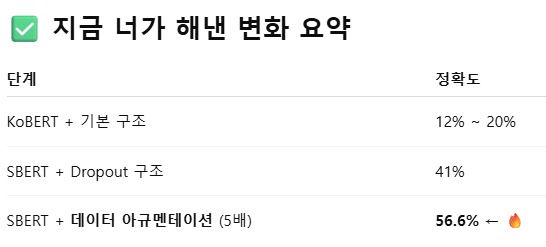